In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Tensors
## Warm-up: numpy

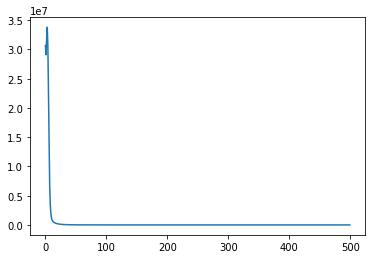

In [2]:
import numpy as np

N, D_in, H, D_out = 64, 1000, 100, 10

x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6

loss_list = []
for t in range(500):
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)
    
    loss = np.square(y_pred - y).sum()
    loss_list.append(loss)
    #print(t, loss)
    
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)
    
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

plt.plot(loss_list)

## PyTorch: Tensors

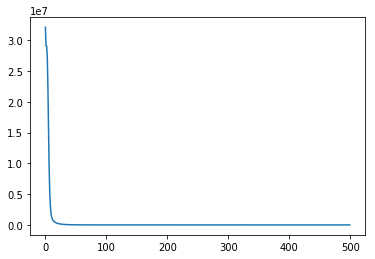

In [3]:
import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6

loss_list = []
for t in range(500):
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    
    loss = (y_pred - y).pow(2).sum().item()
    loss_list.append(loss)
    #print(t, loss)
    
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)
    
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    
plt.plot(loss_list)

# Autograd
## PyTorch: Tensors and autograd

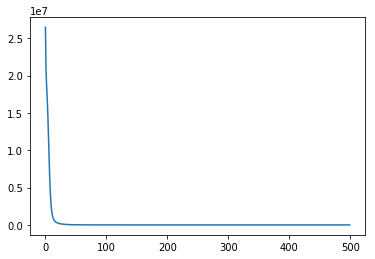

In [4]:
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6

loss_list = []
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    
    loss = (y_pred - y).pow(2).sum()
    loss_list.append(loss)
    #print(t, loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        
        w1.grad.zero_()
        w2.grad.zero_()

plt.plot(loss_list)

## PyTorch: Defining new autograd functions

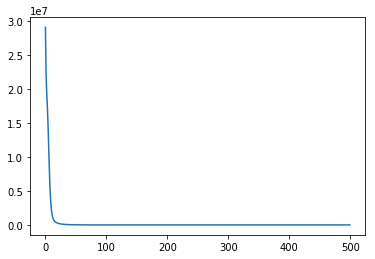

In [5]:
import torch

class MyReLU(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6

loss_list = []
for t in range(500):
    relu = MyReLU.apply
    
    y_pred = relu(x.mm(w1)).mm(w2)
    
    loss = (y_pred - y).pow(2).sum()
    loss_list.append(loss)
    #print(t, loss.itme())
    
    loss.backward()
    
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        
        w1.grad.zero_()
        w2.grad.zero_()

plt.plot(loss_list)

## TensorFlow: Static Graphs

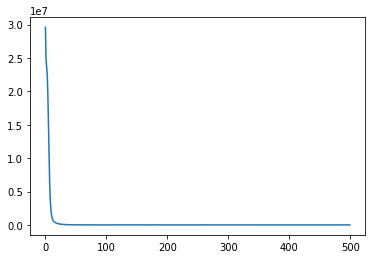

In [6]:
import tensorflow as tf
import numpy as np

N, D_in, H, D_out = 64, 1000, 100, 10

x = tf.placeholder(tf.float32, shape=(None, D_in))
y = tf.placeholder(tf.float32, shape=(None, D_out))

w1 = tf.Variable(tf.random_normal((D_in, H)))
w2 = tf.Variable(tf.random_normal((H, D_out)))

h = tf.matmul(x, w1)
h_relu = tf.maximum(h, tf.zeros(1))
y_pred = tf.matmul(h_relu, w2)

loss = tf.reduce_sum((y - y_pred) ** 2.0)

grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])

learning_rate = 1e-6
new_w1 = w1.assign(w1 - learning_rate * grad_w1)
new_w2 = w2.assign(w2 - learning_rate * grad_w2)

loss_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    x_value = np.random.randn(N, D_in)
    y_value = np.random.randn(N, D_out)
    for t in range(500):
        loss_value, _, _ = sess.run([loss, new_w1, new_w2], feed_dict={x: x_value, y: y_value})
        loss_list.append(loss_value)
        #print(t, loss_value)

plt.plot(loss_list)